# **StyleGANXL + CLIP 🖼️**

## Generate images from text prompts using StyleGANXL with CLIP guidance.

Head over [here](https://github.com/CasualGANPapers/unconditional-StyleGAN-CLIP) if you want to be up to date with the changes to this notebook.

Current to dos:
- Find a good learning rate
- Change optimizer

Largely based on code by  Katherine Crowson (https://github.com/crowsonkb) and nshepperd (https://github.com/nshepperd)

Mostly made possible because of StyleGAN-XL (https://github.com/autonomousvision/stylegan_xl)

Created by Eugenio Herrera and Rodrigo Mello


In [ ]:
#@markdown #**Install libraries and define functions** 🏗️🛠️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

!git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

## I'll probably have to trim stuff here

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 123 (delta 23), reused 100 (delta 9), pack-reused 0
Receiving objects: 100% (123/123), 4.17 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 26.13 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Obtaining file:///content/CLIP
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Running setup.py develop for clip
     |████████████████████████████████| 108 kB 13.1 MB/s 
     |████████████████████████████████| 431 kB 9.8 MB/s 


Using device: cuda:0
100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 220MiB/s]


In [ ]:
#@markdown #**Model selection** 🎭

Model = 'Imagenet' #@param ["Imagenet", "Pokemon"]

#@markdown ---

network_url = {
    "Imagenet": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

--2022-04-01 10:36:25--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.87
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1896392968 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet128.pkl’

imagenet128.pkl     100%[===================>]   1.77G  18.2MB/s    in 99s     

2022-04-01 10:38:05 (18.2 MB/s) - ‘imagenet128.pkl’ saved [1896392968/1896392968]

Setting up PyTorch plugin "bias_act_plugin"... Done.


torch.Size([1, 512])


  0%|          | 0/1001 [00:00<?, ?it/s]

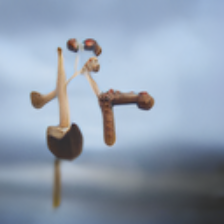

Image 0/1001 | Current loss: 0.8876883387565613


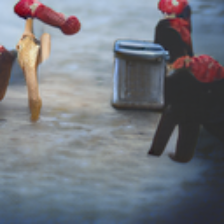

Image 10/1001 | Current loss: 0.8929377794265747


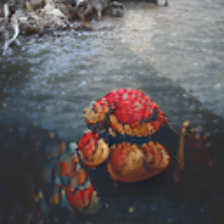

Image 20/1001 | Current loss: 0.9086275696754456


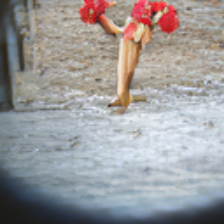

Image 30/1001 | Current loss: 0.9051746726036072


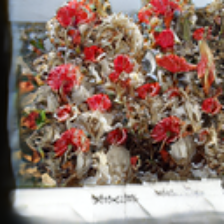

Image 40/1001 | Current loss: 0.8879059553146362


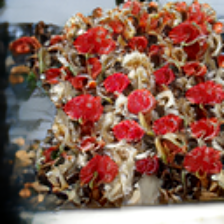

Image 50/1001 | Current loss: 0.8734742403030396


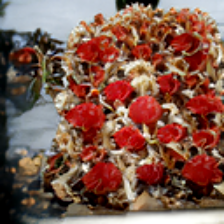

Image 60/1001 | Current loss: 0.8218687772750854


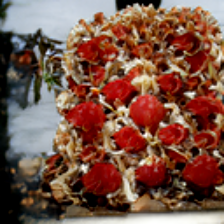

Image 70/1001 | Current loss: 0.7988937497138977


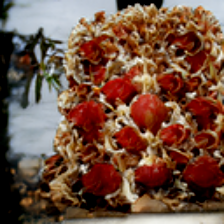

Image 80/1001 | Current loss: 0.7736549377441406


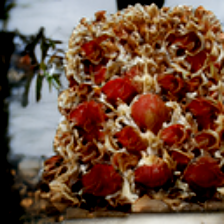

Image 90/1001 | Current loss: 0.7598764896392822


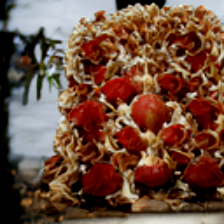

Image 100/1001 | Current loss: 0.7500481009483337


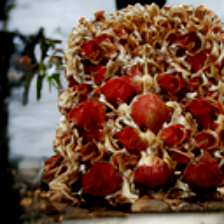

Image 110/1001 | Current loss: 0.7423442602157593


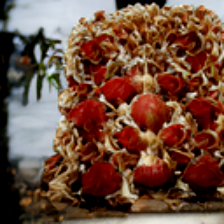

Image 120/1001 | Current loss: 0.7350457310676575


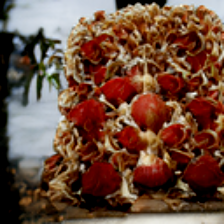

Image 130/1001 | Current loss: 0.7298882603645325


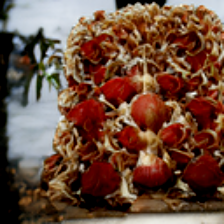

Image 140/1001 | Current loss: 0.7489617466926575


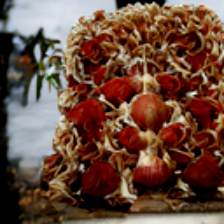

Image 150/1001 | Current loss: 0.7507556676864624


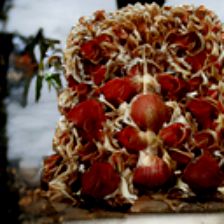

Image 160/1001 | Current loss: 0.7365673184394836


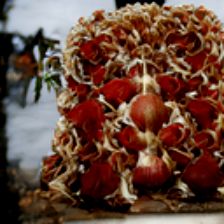

Image 170/1001 | Current loss: 0.7391898036003113


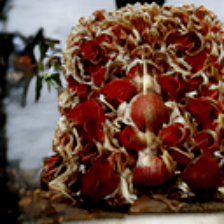

Image 180/1001 | Current loss: 0.7269232869148254


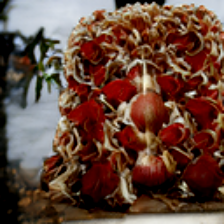

Image 190/1001 | Current loss: 0.7341550588607788


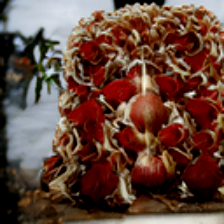

Image 200/1001 | Current loss: 0.7336015105247498


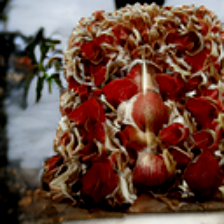

Image 210/1001 | Current loss: 0.7263468503952026


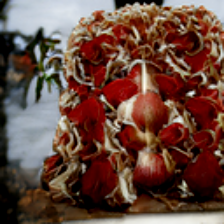

Image 220/1001 | Current loss: 0.7295213341712952


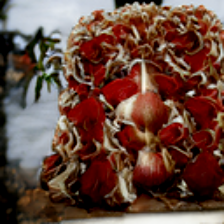

Image 230/1001 | Current loss: 0.7259613871574402


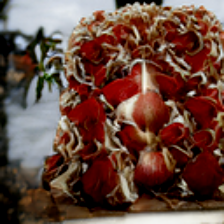

Image 240/1001 | Current loss: 0.7213826179504395


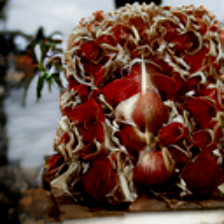

Image 250/1001 | Current loss: 0.7211059927940369


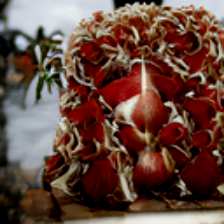

Image 260/1001 | Current loss: 0.7243186235427856


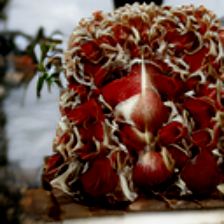

Image 270/1001 | Current loss: 0.7092729806900024


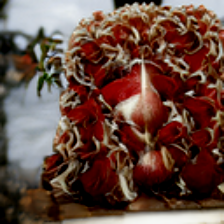

Image 280/1001 | Current loss: 0.7023882269859314


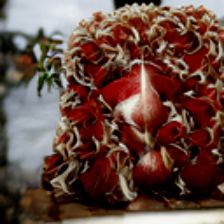

Image 290/1001 | Current loss: 0.7073358297348022


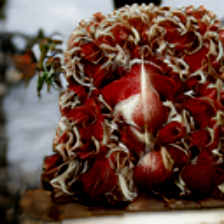

Image 300/1001 | Current loss: 0.7263043522834778


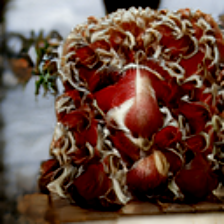

Image 310/1001 | Current loss: 0.7578484416007996


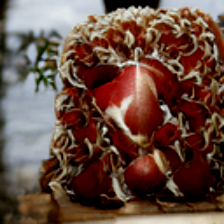

Image 320/1001 | Current loss: 0.7381235361099243


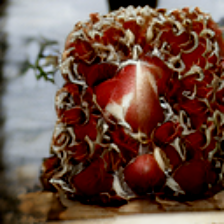

Image 330/1001 | Current loss: 0.7238690257072449


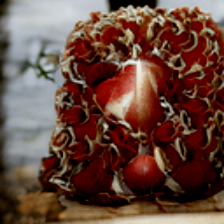

Image 340/1001 | Current loss: 0.7190923690795898


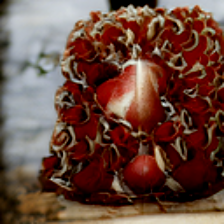

Image 350/1001 | Current loss: 0.7161970734596252


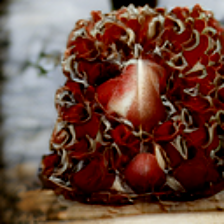

Image 360/1001 | Current loss: 0.7060019969940186


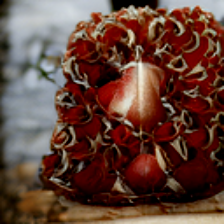

Image 370/1001 | Current loss: 0.7022820711135864


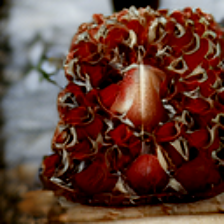

Image 380/1001 | Current loss: 0.7204862236976624


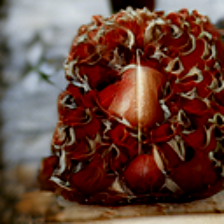

Image 390/1001 | Current loss: 0.7159803509712219


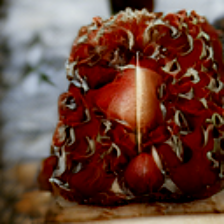

Image 400/1001 | Current loss: 0.6956726908683777


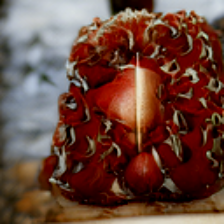

Image 410/1001 | Current loss: 0.6866868734359741


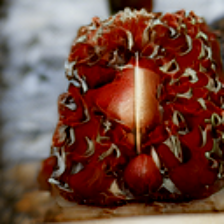

Image 420/1001 | Current loss: 0.6889830827713013


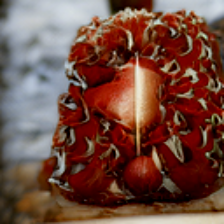

Image 430/1001 | Current loss: 0.6962848901748657


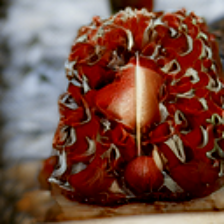

Image 440/1001 | Current loss: 0.6872608661651611


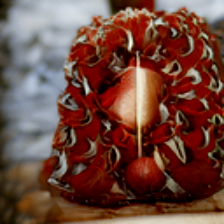

Image 450/1001 | Current loss: 0.7003852725028992


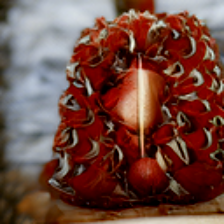

Image 460/1001 | Current loss: 0.6871605515480042


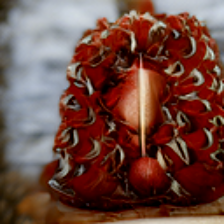

Image 470/1001 | Current loss: 0.6793628931045532


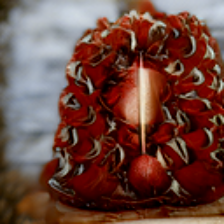

Image 480/1001 | Current loss: 0.6708290576934814


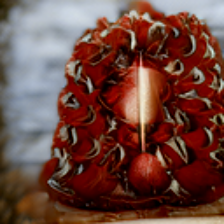

Image 490/1001 | Current loss: 0.6894274950027466


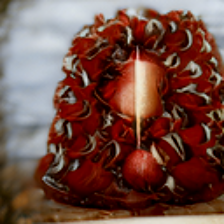

Image 500/1001 | Current loss: 0.7269458174705505


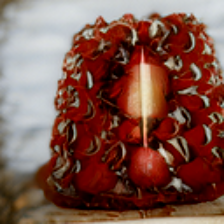

Image 510/1001 | Current loss: 0.7257803082466125


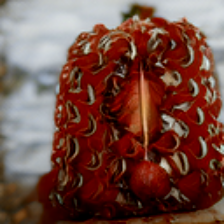

Image 520/1001 | Current loss: 0.7742213606834412


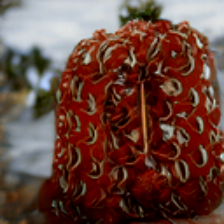

Image 530/1001 | Current loss: 0.7634319067001343


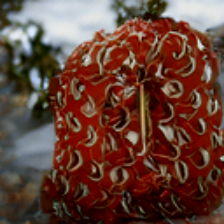

Image 540/1001 | Current loss: 0.7448099851608276


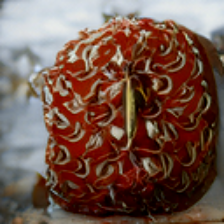

Image 550/1001 | Current loss: 0.808021605014801


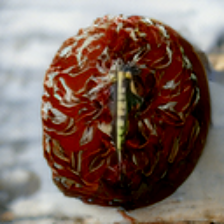

Image 560/1001 | Current loss: 0.7703596949577332


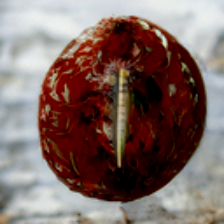

Image 570/1001 | Current loss: 0.7245482206344604


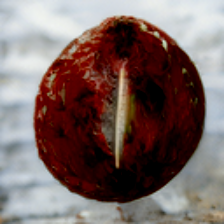

Image 580/1001 | Current loss: 0.7154077291488647


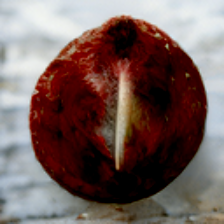

Image 590/1001 | Current loss: 0.7013739347457886


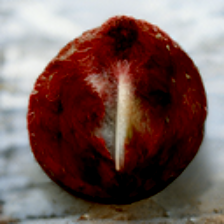

Image 600/1001 | Current loss: 0.6920913457870483


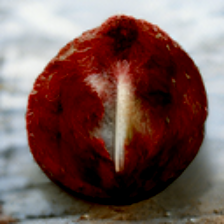

Image 610/1001 | Current loss: 0.6861259341239929


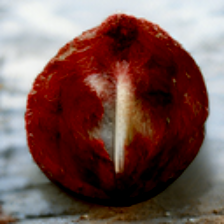

Image 620/1001 | Current loss: 0.6924031972885132


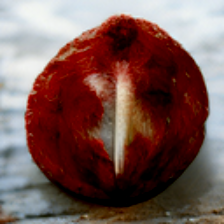

Image 630/1001 | Current loss: 0.6828364729881287


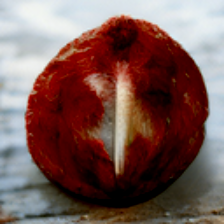

Image 640/1001 | Current loss: 0.684054434299469


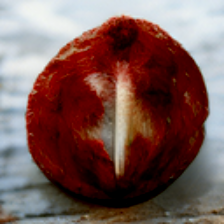

Image 650/1001 | Current loss: 0.6765429377555847


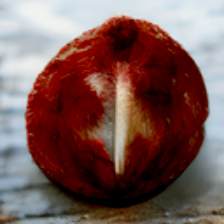

Image 660/1001 | Current loss: 0.6722996234893799


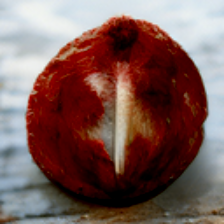

Image 670/1001 | Current loss: 0.6799067258834839


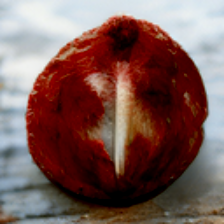

Image 680/1001 | Current loss: 0.6707967519760132


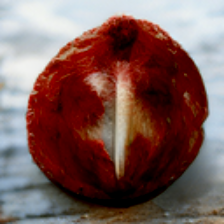

Image 690/1001 | Current loss: 0.6716117858886719


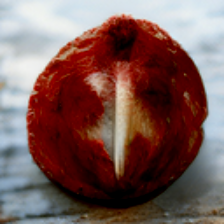

Image 700/1001 | Current loss: 0.6801234483718872


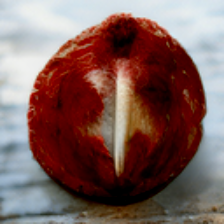

Image 710/1001 | Current loss: 0.7135860919952393


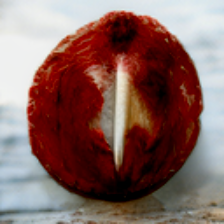

Image 720/1001 | Current loss: 0.6975154876708984


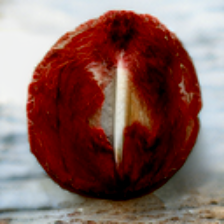

Image 730/1001 | Current loss: 0.7081076502799988


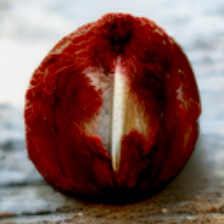

Image 740/1001 | Current loss: 0.7102681994438171


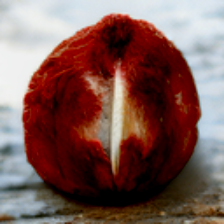

Image 750/1001 | Current loss: 0.6883177161216736


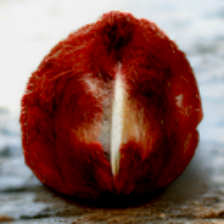

Image 760/1001 | Current loss: 0.6977243423461914


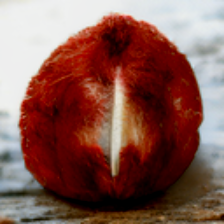

Image 770/1001 | Current loss: 0.6955336332321167


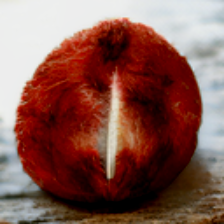

Image 780/1001 | Current loss: 0.7138145565986633


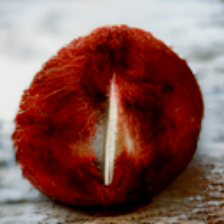

Image 790/1001 | Current loss: 0.6996193528175354


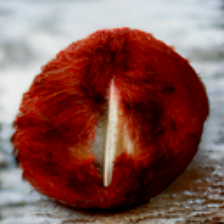

Image 800/1001 | Current loss: 0.6898413300514221


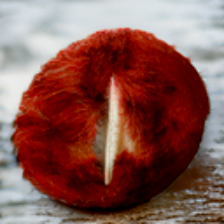

Image 810/1001 | Current loss: 0.6982973217964172


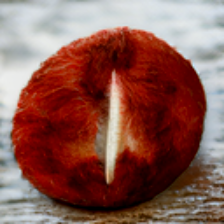

Image 820/1001 | Current loss: 0.691418468952179


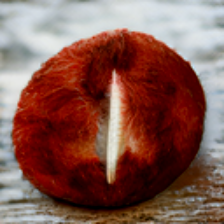

Image 830/1001 | Current loss: 0.6933699250221252


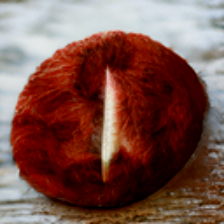

Image 840/1001 | Current loss: 0.7129009962081909


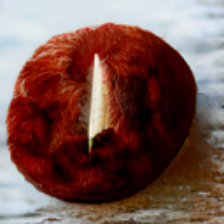

Image 850/1001 | Current loss: 0.7535408139228821


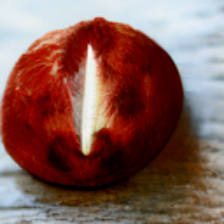

Image 860/1001 | Current loss: 0.7237334847450256


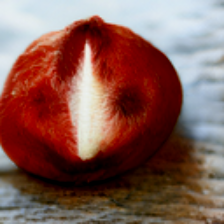

Image 870/1001 | Current loss: 0.7004410028457642


In [ ]:
#@markdown #**Run the model** 🚀
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

texts = "a juicy red apple"#@param {type:"string"}
steps = 1001#@param {type:"number"}
seed = 2513304592#@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


'''
zs = torch.randn([10000, G.mapping.z_dim], device=device)
one_hot_class = torch.zeros(1000)
initial_class = torch.randint(0,1000, (1,))[0]
one_hot_class[initial_class]=1
one_hot_class = one_hot_class.repeat((10000, 1))
cs = one_hot_class.to(device)
w_stds = G.mapping(zs, cs)
w_stds=w_stds.std(0)[0]
'''




tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

initial_batch=4 #actually that will be multiplied by initial_image_steps
initial_image_steps=8
'''
c = torch.zeros((1000)) #just to pick a closer initial image
c[initial_class]=1
c = c.repeat(initial_batch, 1)
c=c.to(device)
'''
def run(timestring):
  torch.manual_seed(seed)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(initial_image_steps):
      a = torch.randn([initial_batch, 512], device=device)*0.6 + w_stds*0.4
      q = ((a-w_all_classes_avg)/w_stds)
      images = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    # print(losses)
    # print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()


  # Sampling loop
  q_ema = q
  print (q.shape)
  opt = torch.optim.AdamW([q], lr=0.05, betas=(0.5,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]), noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis((q_ema * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]), noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass